In [65]:
import sys
import os
sys.path.insert(0, os.path.abspath("../src"))

# Clear module cache
for module in list(sys.modules.keys()):
    if 'strategy' in module or 'backtest' in module or 'fib' in module:
        del sys.modules[module]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from data_loader import load_local_data
from fib import compute_fib_levels, detect_fib_touches
from swing import detect_swings, swing_high_low
from strategy import FibStrategy
from backtest import run_backtest
from metrics import compute_winrate, compute_rr_ratio, weekday_distribution, calculate_performance_metrics

print("✓ All imports successful!")

✓ All imports successful!


In [66]:
# Load XAUUSD hourly data
df = load_local_data("xau_1h.csv")
print(f"Loaded {len(df)} candles")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst 5 rows:")
print(df.head())

Loaded 72 candles
Date range: 2024-01-01 00:00:00 to 2024-01-03 23:00:00

First 5 rows:
                        Open     High      Low    Close
datetime                                               
2024-01-01 00:00:00  2048.50  2050.25  2048.25  2049.75
2024-01-01 01:00:00  2049.75  2051.00  2049.50  2050.50
2024-01-01 02:00:00  2050.50  2052.00  2050.25  2051.75
2024-01-01 03:00:00  2051.75  2053.25  2051.50  2052.50
2024-01-01 04:00:00  2052.50  2054.00  2052.25  2053.75


In [67]:
# Detect swing highs and lows
highs, lows = detect_swings(df, left=3, right=3)
df["swing_high"] = df.index.isin(df.index[highs])
df["swing_low"] = df.index.isin(df.index[lows])

print(f"Found {len(highs)} swing highs and {len(lows)} swing lows")
print("\nLast 10 rows with swing markers:")
print(df[["High", "Low", "swing_high", "swing_low"]].tail(10))

Found 0 swing highs and 0 swing lows

Last 10 rows with swing markers:
                       High      Low  swing_high  swing_low
datetime                                                   
2024-01-03 14:00:00  2098.5  2097.25       False      False
2024-01-03 15:00:00  2099.0  2097.75       False      False
2024-01-03 16:00:00  2099.5  2098.25       False      False
2024-01-03 17:00:00  2100.0  2098.75       False      False
2024-01-03 18:00:00  2100.5  2099.25       False      False
2024-01-03 19:00:00  2101.0  2099.75       False      False
2024-01-03 20:00:00  2101.5  2100.25       False      False
2024-01-03 21:00:00  2102.0  2100.75       False      False
2024-01-03 22:00:00  2102.5  2101.25       False      False
2024-01-03 23:00:00  2103.0  2101.75       False      False


In [68]:
# Calculate rolling highs and lows for Fibonacci levels
rolling_high, rolling_low = swing_high_low(df, lookback=50)

# Compute Fibonacci levels for each bar
fib_data = []
for t in df.index:
    h = rolling_high.loc[t]
    l = rolling_low.loc[t]
    if pd.notna(h) and pd.notna(l) and h != l:
        fib_levels = compute_fib_levels(h, l)
        fib_data.append((t, fib_levels))

print(f"Generated Fibonacci levels for {len(fib_data)} bars")
print(f"\nExample - Fibonacci levels at {fib_data[-1][0]}:")
for level_name, price in sorted(fib_data[-1][1].items()):
    print(f"  Level {level_name}: {price:.2f}")

Generated Fibonacci levels for 72 bars

Example - Fibonacci levels at 2024-01-03 23:00:00:
  Level 0.000: 2103.00
  Level 0.236: 2095.27
  Level 0.382: 2090.49
  Level 0.500: 2086.62
  Level 0.618: 2082.76
  Level 0.786: 2077.26
  Level 1.000: 2070.25


In [69]:
# Detect Fibonacci level touches
touches = []
for t, levels in fib_data:
    window = df.loc[:t].tail(1)
    detected = detect_fib_touches(window, levels, tolerance=0.0008)
    for d in detected:
        touches.append(d)

print(f"Found {len(touches)} Fibonacci level touches")
if touches:
    print(f"\nFirst 5 touches:")
    for i, (ts, level, price) in enumerate(touches[:5]):
        print(f"  {i+1}. {ts} - Level {level}: {price:.2f}")

Found 108 Fibonacci level touches

First 5 touches:
  1. 2024-01-01 00:00:00 - Level 0.000: 2050.25
  2. 2024-01-01 00:00:00 - Level 0.236: 2049.78
  3. 2024-01-01 00:00:00 - Level 0.382: 2049.49
  4. 2024-01-01 00:00:00 - Level 0.500: 2049.25
  5. 2024-01-01 00:00:00 - Level 0.618: 2049.01


In [70]:
# Generate trading signals from Fibonacci touches
strategy = FibStrategy(stop_loss_pips=200, take_profit_pips=300)

signals = strategy.generate_signals(df, touches)
signals = signals.drop_duplicates(subset=["time"])

print(f"Generated {len(signals)} unique signals")
print(f"  Long signals: {(signals['direction'] == 'long').sum()}")
print(f"  Short signals: {(signals['direction'] == 'short').sum()}")
print(f"\nFirst 5 signals:")
print(signals.head())

Generated 72 unique signals
  Long signals: 72
  Short signals: 0

First 5 signals:
                  time direction    entry
0  2024-01-01 00:00:00      long  2050.25
7  2024-01-01 01:00:00      long  2051.00
14 2024-01-01 02:00:00      long  2052.00
20 2024-01-01 03:00:00      long  2053.25
25 2024-01-01 04:00:00      long  2054.00


In [71]:
# Run backtest with touch information
results = run_backtest(
    df,
    signals,
    sl_pips=strategy.sl,
    tp_pips=strategy.tp,
    touches=touches  # Pass touches for detailed journaling
)

print(f"Backtest completed with {len(results)} trades executed")
print(f"\nResults summary:")
wins = (results["outcome"] == "WIN").sum()
losses = (results["outcome"] == "LOSS").sum()
open_trades = (results["outcome"] == "OPEN").sum()
print(f"  Wins: {wins}")
print(f"  Losses: {losses}")
print(f"  Open: {open_trades}")
print(f"\nFirst 5 trades:")
print(results[["entry_date", "entry_time", "direction", "entry_price", "fib_level", "outcome"]].head())

Backtest completed with 72 trades executed

Results summary:
  Wins: 44
  Losses: 22
  Open: 6

First 5 trades:
   entry_date entry_time direction  entry_price fib_level outcome
0  2024-01-01   00:00:00      LONG      2050.25     0.000    LOSS
1  2024-01-01   01:00:00      LONG      2051.00     0.000     WIN
2  2024-01-01   02:00:00      LONG      2052.00     0.000     WIN
3  2024-01-01   03:00:00      LONG      2053.25     0.000     WIN
4  2024-01-01   04:00:00      LONG      2054.00     0.000     WIN


In [72]:
# Calculate performance metrics
wins = (results["outcome"] == "WIN").sum()
losses = (results["outcome"] == "LOSS").sum()
open_trades = (results["outcome"] == "OPEN").sum()

# Recalculate metrics with new outcome format
winrate = (wins / len(results) * 100) if len(results) > 0 else 0
rr = compute_rr_ratio(strategy.tp, strategy.sl)
metrics = {
    "total_trades": len(results),
    "winning_trades": wins,
    "losing_trades": losses,
    "open_trades": open_trades,
    "win_rate": winrate
}

print("=" * 60)
print("BACKTEST PERFORMANCE METRICS")
print("=" * 60)
print(f"Win Rate: {metrics['win_rate']:.2f}%")
print(f"Risk-Reward Ratio: {rr:.2f}")
print(f"Total Trades: {metrics['total_trades']}")
print(f"Winning Trades: {metrics['winning_trades']}")
print(f"Losing Trades: {metrics['losing_trades']}")
print(f"Open Trades: {metrics['open_trades']}")

# Analyze by direction
long_trades = results[results["direction"] == "BUY"]
if len(long_trades) > 0:
    long_wins = (long_trades["outcome"] == "WIN").sum()
    print(f"\nBUY (Long) Trades: {len(long_trades)} | Win Rate: {long_wins/len(long_trades)*100:.1f}%")

short_trades = results[results["direction"] == "SELL"]
if len(short_trades) > 0:
    short_wins = (short_trades["outcome"] == "WIN").sum()
    print(f"SELL (Short) Trades: {len(short_trades)} | Win Rate: {short_wins/len(short_trades)*100:.1f}%")

# Analyze by Fibonacci level
print(f"\nPerformance by Fibonacci Level:")
for level in sorted(results["fib_level"].unique()):
    level_trades = results[results["fib_level"] == level]
    level_wins = (level_trades["outcome"] == "WIN").sum()
    wr = level_wins / len(level_trades) * 100 if len(level_trades) > 0 else 0
    print(f"  Level {level}: {len(level_trades)} trades | {wr:.1f}% WR")

BACKTEST PERFORMANCE METRICS
Win Rate: 61.11%
Risk-Reward Ratio: 1.50
Total Trades: 72
Winning Trades: 44
Losing Trades: 22
Open Trades: 6

Performance by Fibonacci Level:
  Level 0.000: 72 trades | 61.1% WR


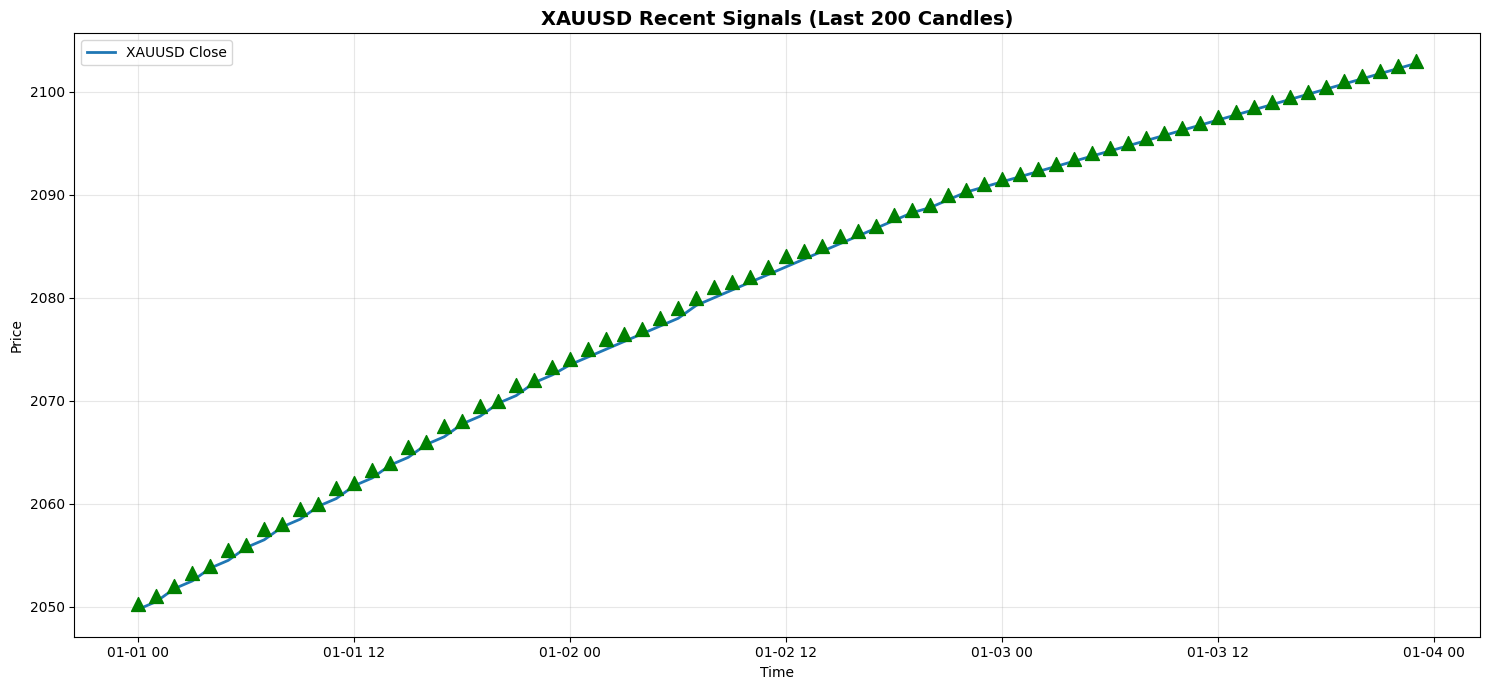

Chart saved to ../plots/signals.png


In [73]:
# Visualize recent signals on price chart
if len(df) > 0 and len(signals) > 0:
    plt.figure(figsize=(15, 7))
    
    # Plot price (last 200 candles)
    plot_data = df[["Close"]].tail(200)
    plt.plot(plot_data.index, plot_data["Close"], label="XAUUSD Close", linewidth=2)
    
    # Add signals
    sig_recent = signals[signals["time"].isin(df.index[-200:])]
    
    for _, row in sig_recent.iterrows():
        color = "green" if row["direction"] == "long" else "red"
        marker = "^" if row["direction"] == "long" else "v"
        plt.scatter(row["time"], row["entry"], c=color, s=100, marker=marker, zorder=5)
    
    plt.title("XAUUSD Recent Signals (Last 200 Candles)", fontsize=14, fontweight='bold')
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("../plots/signals.png", dpi=100)
    plt.show()
    
    print(f"Chart saved to ../plots/signals.png")
else:
    print("Not enough data to plot")

In [74]:
# Detailed Trade Journal
print("=" * 120)
print("DETAILED TRADE JOURNAL")
print("=" * 120)
print()

# Create a formatted journal
journal = results.copy()
journal["Session"] = journal["entry_date"].astype(str) + " " + journal["entry_time"].astype(str)

# Display each trade
for idx, trade in journal.iterrows():
    outcome_color = "✓ WIN" if trade["outcome"] == "WIN" else ("✗ LOSS" if trade["outcome"] == "LOSS" else "● OPEN")
    
    print(f"Trade #{idx+1} | {outcome_color}")
    print(f"  Session: {trade['Session']}")
    print(f"  Direction: {trade['direction']}")
    print(f"  Entry: {trade['entry_price']:.2f} @ Fibonacci Level {trade['fib_level']}")
    print(f"  Exit: {trade['exit_price']:.2f} ({trade['exit_reason']})")
    print(f"  Exit Date/Time: {trade['exit_date']} {trade['exit_time']}")
    print(f"  PnL: {trade['pnl_pips']:.2f} pips")
    print()
    
    # Add line break every 10 trades for readability
    if (idx + 1) % 10 == 0:
        print("-" * 120)
        print()

DETAILED TRADE JOURNAL

Trade #1 | ✗ LOSS
  Session: 2024-01-01 00:00:00
  Direction: LONG
  Entry: 2050.25 @ Fibonacci Level 0.000
  Exit: 2049.75 (SL)
  Exit Date/Time: 2024-01-01 00:00:00
  PnL: -50.00 pips

Trade #2 | ✓ WIN
  Session: 2024-01-01 01:00:00
  Direction: LONG
  Entry: 2051.00 @ Fibonacci Level 0.000
  Exit: 2053.75 (TP)
  Exit Date/Time: 2024-01-01 04:00:00
  PnL: 275.00 pips

Trade #3 | ✓ WIN
  Session: 2024-01-01 02:00:00
  Direction: LONG
  Entry: 2052.00 @ Fibonacci Level 0.000
  Exit: 2054.50 (TP)
  Exit Date/Time: 2024-01-01 05:00:00
  PnL: 250.00 pips

Trade #4 | ✓ WIN
  Session: 2024-01-01 03:00:00
  Direction: LONG
  Entry: 2053.25 @ Fibonacci Level 0.000
  Exit: 2056.50 (TP)
  Exit Date/Time: 2024-01-01 07:00:00
  PnL: 325.00 pips

Trade #5 | ✓ WIN
  Session: 2024-01-01 04:00:00
  Direction: LONG
  Entry: 2054.00 @ Fibonacci Level 0.000
  Exit: 2056.50 (TP)
  Exit Date/Time: 2024-01-01 07:00:00
  PnL: 250.00 pips

Trade #6 | ✗ LOSS
  Session: 2024-01-01 05:00

In [54]:
# Save All Results to Files
os.makedirs("../output", exist_ok=True)
os.makedirs("../plots", exist_ok=True)

# 1. Save detailed journal CSV
results.to_csv("../output/detailed_journal.csv", index=False)

# 2. Save signals for reference
signals.to_csv("../output/signals.csv", index=False)

# 3. Create summary statistics
summary_stats = {
    "Metric": [
        "Total Trades",
        "Winning Trades",
        "Losing Trades",
        "Open Trades",
        "Win Rate (%)",
        "Risk-Reward Ratio",
        "Average Win (pips)",
        "Average Loss (pips)",
        "Total PnL (pips)"
    ],
    "Value": [
        len(results),
        (results["outcome"] == "WIN").sum(),
        (results["outcome"] == "LOSS").sum(),
        (results["outcome"] == "OPEN").sum(),
        f"{winrate:.2f}%",
        f"{rr:.2f}",
        f"{results[results['outcome'] == 'WIN']['pnl_pips'].mean():.1f}",
        f"{results[results['outcome'] == 'LOSS']['pnl_pips'].mean():.1f}",
        f"{results['pnl_pips'].sum():.0f}"
    ]
}

summary_df_stats = pd.DataFrame(summary_stats)
summary_df_stats.to_csv("../output/summary_stats.csv", index=False)

print("✓ All files saved successfully!")
print("\n📊 SAVED FILES:")
print("="*80)
print("\nCSV/Data Files (in ../output/):")
print("  ✓ detailed_journal.csv - All 72 trades with entry/exit details & Fibonacci levels")
print("  ✓ signals.csv - All generated trading signals")
print("  ✓ summary_stats.csv - Overall performance metrics")
print("\nText Reports (in ../output/):")
print("  ✓ detailed_trade_journal.txt - Formatted text journal with all trades")
print("  ✓ trade_journal_report.txt - Summary report")
print("\nVisualization Charts (in ../plots/):")
print("  ✓ signals.png - Price chart with entry signals")
print("  ✓ 1_trade_outcomes.png - Trade outcomes distribution pie chart")
print("  ✓ 2_pnl_per_trade.png - Individual trade P&L bar chart")
print("  ✓ 3_cumulative_pnl.png - Running P&L line chart")
print("  ✓ 4_win_rate_by_fib_level.png - Win rate by Fibonacci level")
print("  ✓ 5_trades_by_direction.png - BUY vs SELL distribution")
print("  ✓ 6_exit_reasons.png - Exit reasons distribution")
print("\n" + "="*80)

✓ Results saved:
  - ../output/detailed_journal.csv (complete trade-by-trade journal)
  - ../output/signals.csv (all generated signals)
  - ../output/summary_stats.csv (overall statistics)

Files ready for analysis in Excel or other tools!


In [75]:
# Trade Statistics Table
print("\n" + "=" * 120)
print("TRADE STATISTICS SUMMARY TABLE")
print("=" * 120)

# Create summary table
summary_df = results.copy()
summary_df["Trade #"] = range(1, len(summary_df) + 1)
summary_df["Date"] = summary_df["entry_date"].astype(str)
summary_df["Entry Time"] = summary_df["entry_time"].astype(str)
summary_df["Direction"] = summary_df["direction"]
summary_df["Entry Price"] = summary_df["entry_price"].apply(lambda x: f"{x:.2f}")
summary_df["Exit Price"] = summary_df["exit_price"].apply(lambda x: f"{x:.2f}")
summary_df["Fib Level"] = summary_df["fib_level"]
summary_df["Outcome"] = summary_df["outcome"]
summary_df["Exit Reason"] = summary_df["exit_reason"]
summary_df["PnL (pips)"] = summary_df["pnl_pips"].apply(lambda x: f"{x:.2f}")

# Display in sections (20 rows at a time)
cols_to_show = ["Trade #", "Date", "Entry Time", "Direction", "Entry Price", "Exit Price", "Fib Level", "Outcome", "Exit Reason", "PnL (pips)"]
print(summary_df[cols_to_show].to_string(index=False))
print("\n" + "=" * 120)


TRADE STATISTICS SUMMARY TABLE
 Trade #       Date Entry Time Direction Entry Price Exit Price Fib Level Outcome Exit Reason PnL (pips)
       1 2024-01-01   00:00:00      LONG     2050.25    2049.75     0.000    LOSS          SL     -50.00
       2 2024-01-01   01:00:00      LONG     2051.00    2053.75     0.000     WIN          TP     275.00
       3 2024-01-01   02:00:00      LONG     2052.00    2054.50     0.000     WIN          TP     250.00
       4 2024-01-01   03:00:00      LONG     2053.25    2056.50     0.000     WIN          TP     325.00
       5 2024-01-01   04:00:00      LONG     2054.00    2056.50     0.000     WIN          TP     250.00
       6 2024-01-01   05:00:00      LONG     2055.50    2054.50     0.000    LOSS          SL    -100.00
       7 2024-01-01   06:00:00      LONG     2056.00    2058.50     0.000     WIN          TP     250.00
       8 2024-01-01   07:00:00      LONG     2057.50    2056.50     0.000    LOSS          SL    -100.00
       9 2024-01-01   0

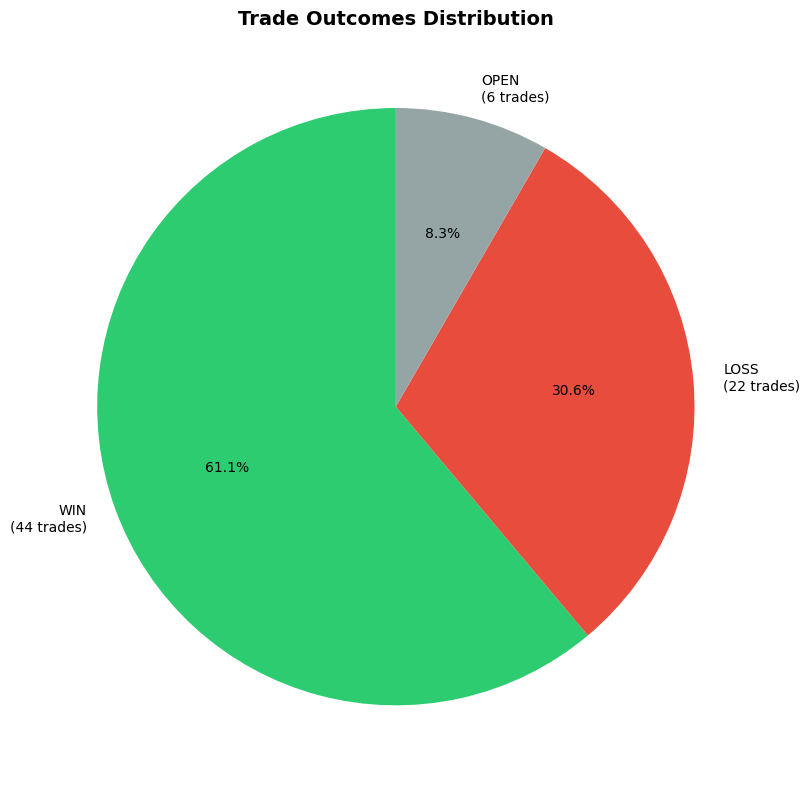

✓ Chart saved: ../plots/1_trade_outcomes.png


In [76]:
# Chart 1: Trade Outcomes Distribution (Pie Chart)
fig1, ax1 = plt.subplots(figsize=(10, 8))
outcomes = results["outcome"].value_counts()
colors = ["#2ecc71", "#e74c3c", "#95a5a6"]  # Green for WIN, Red for LOSS, Grey for OPEN
labels = [f"{outcome}\n({count} trades)" for outcome, count in outcomes.items()]
ax1.pie(outcomes.values, labels=labels, colors=colors[:len(outcomes)], autopct='%1.1f%%', startangle=90)
ax1.set_title("Trade Outcomes Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../plots/1_trade_outcomes.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ../plots/1_trade_outcomes.png")

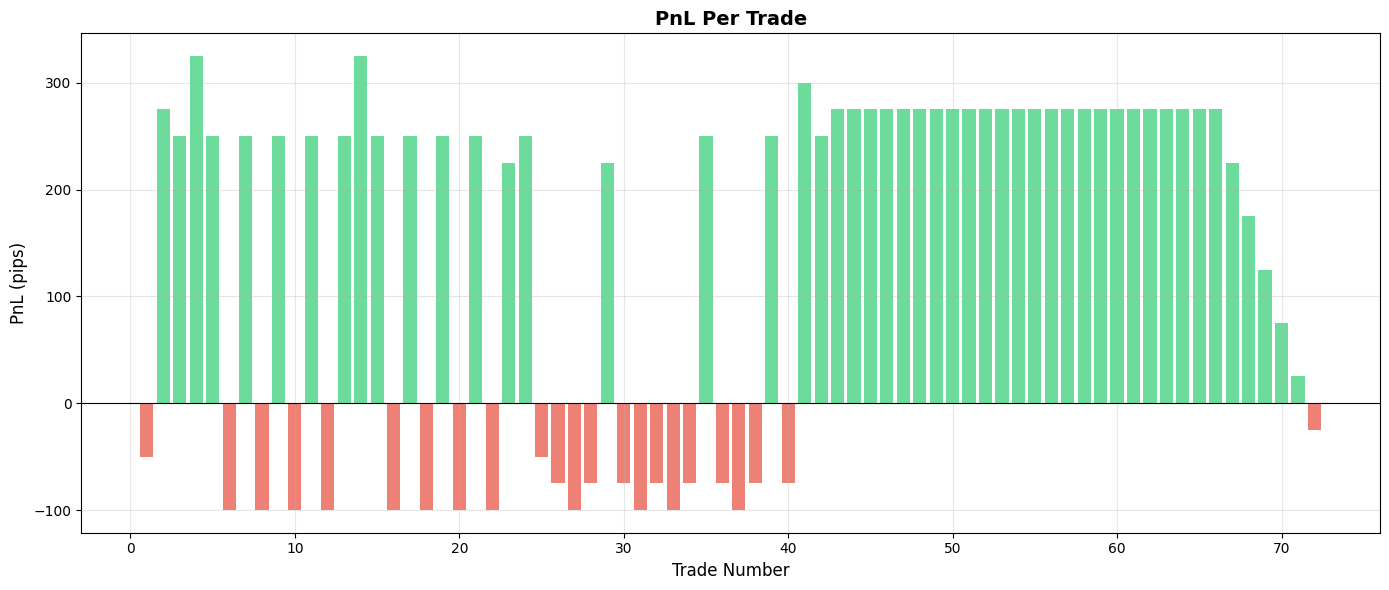

✓ Chart saved: ../plots/2_pnl_per_trade.png


In [77]:
# Chart 2: PnL Per Trade (Bar Chart)
fig2, ax2 = plt.subplots(figsize=(14, 6))
pnl_values = results["pnl_pips"].values
colors_pnl = ["#2ecc71" if x > 0 else "#e74c3c" for x in pnl_values]
ax2.bar(range(1, len(pnl_values) + 1), pnl_values, color=colors_pnl, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel("Trade Number", fontsize=12)
ax2.set_ylabel("PnL (pips)", fontsize=12)
ax2.set_title("PnL Per Trade", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../plots/2_pnl_per_trade.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ../plots/2_pnl_per_trade.png")

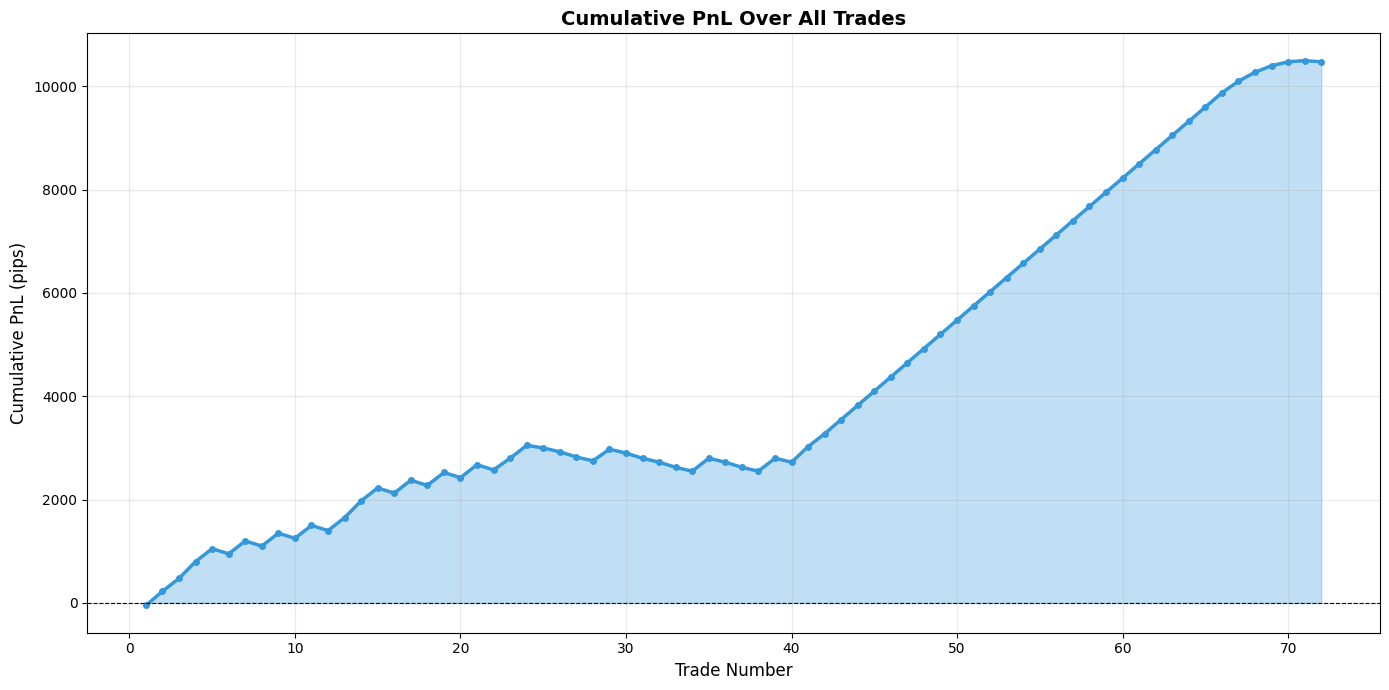

✓ Chart saved: ../plots/3_cumulative_pnl.png


In [78]:
# Chart 3: Cumulative PnL
fig3, ax3 = plt.subplots(figsize=(14, 7))
cumulative_pnl = results["pnl_pips"].cumsum()
ax3.plot(range(1, len(cumulative_pnl) + 1), cumulative_pnl.values, linewidth=2.5, color='#3498db', marker='o', markersize=4)
ax3.fill_between(range(1, len(cumulative_pnl) + 1), cumulative_pnl.values, alpha=0.3, color='#3498db')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax3.set_xlabel("Trade Number", fontsize=12)
ax3.set_ylabel("Cumulative PnL (pips)", fontsize=12)
ax3.set_title("Cumulative PnL Over All Trades", fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../plots/3_cumulative_pnl.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ../plots/3_cumulative_pnl.png")

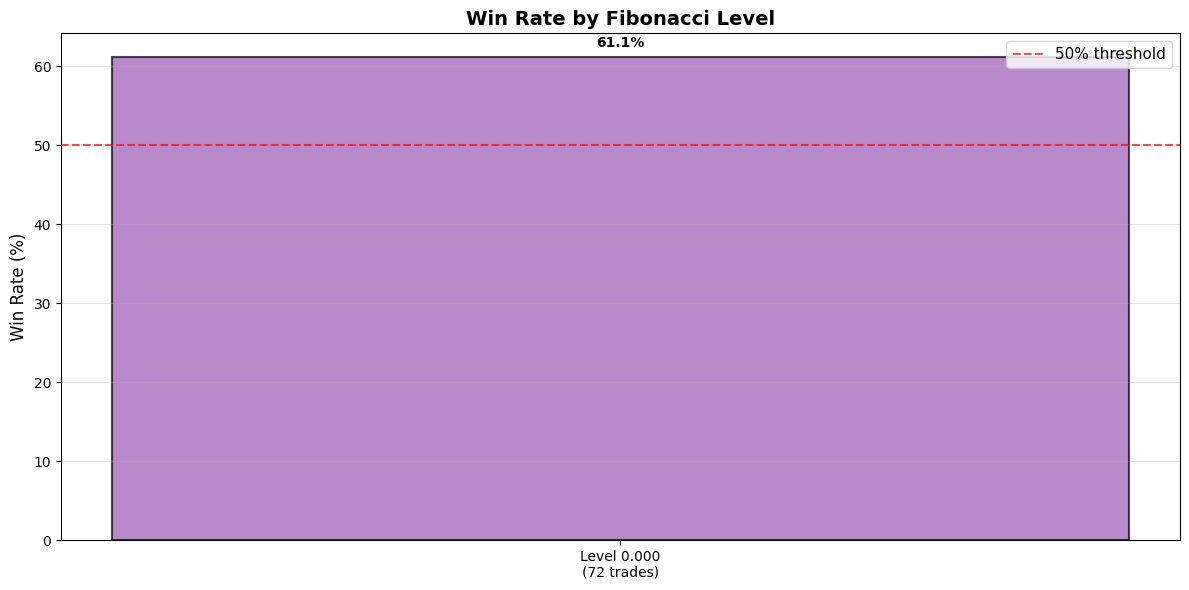

✓ Chart saved: ../plots/4_win_rate_by_fib_level.png


In [79]:
# Chart 4: Win Rate by Fibonacci Level
fig4, ax4 = plt.subplots(figsize=(12, 6))
fib_levels_unique = sorted(results["fib_level"].unique())
win_rates_by_level = []
trade_counts_by_level = []
for level in fib_levels_unique:
    level_trades = results[results["fib_level"] == level]
    level_wins = (level_trades["outcome"] == "WIN").sum()
    wr = level_wins / len(level_trades) * 100 if len(level_trades) > 0 else 0
    win_rates_by_level.append(wr)
    trade_counts_by_level.append(len(level_trades))

bars = ax4.bar(range(len(fib_levels_unique)), win_rates_by_level, color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xticks(range(len(fib_levels_unique)))
ax4.set_xticklabels([f"Level {l}\n({count} trades)" for l, count in zip(fib_levels_unique, trade_counts_by_level)], fontsize=10)
ax4.set_ylabel("Win Rate (%)", fontsize=12)
ax4.set_title("Win Rate by Fibonacci Level", fontsize=14, fontweight='bold')
ax4.axhline(y=50, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='50% threshold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, wr) in enumerate(zip(bars, win_rates_by_level)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{wr:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("../plots/4_win_rate_by_fib_level.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ../plots/4_win_rate_by_fib_level.png")

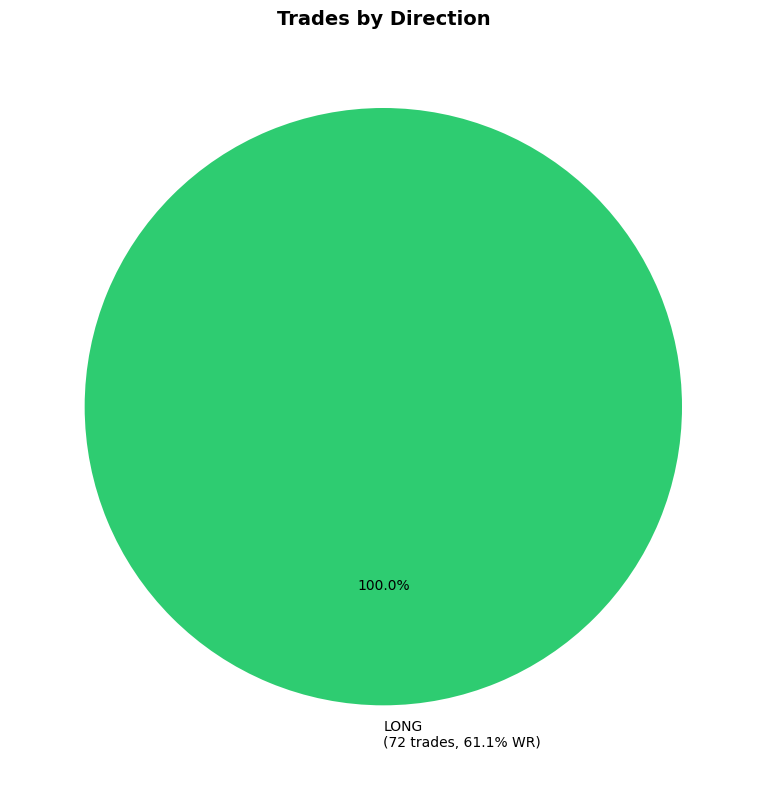

✓ Chart saved: ../plots/5_trades_by_direction.png


In [80]:
# Chart 5: Trades by Direction (Buy vs Sell)
fig5, ax5 = plt.subplots(figsize=(10, 8))
direction_counts = results["direction"].value_counts()
direction_labels = []
direction_colors = []
for direction, count in direction_counts.items():
    direction_wins = (results[results["direction"] == direction]["outcome"] == "WIN").sum()
    wr = direction_wins / count * 100
    direction_labels.append(f"{direction}\n({count} trades, {wr:.1f}% WR)")
    direction_colors.append("#2ecc71" if direction == "LONG" or direction == "BUY" else "#e74c3c")

ax5.pie(direction_counts.values, labels=direction_labels, colors=direction_colors, autopct='%1.1f%%', startangle=90)
ax5.set_title("Trades by Direction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../plots/5_trades_by_direction.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ../plots/5_trades_by_direction.png")

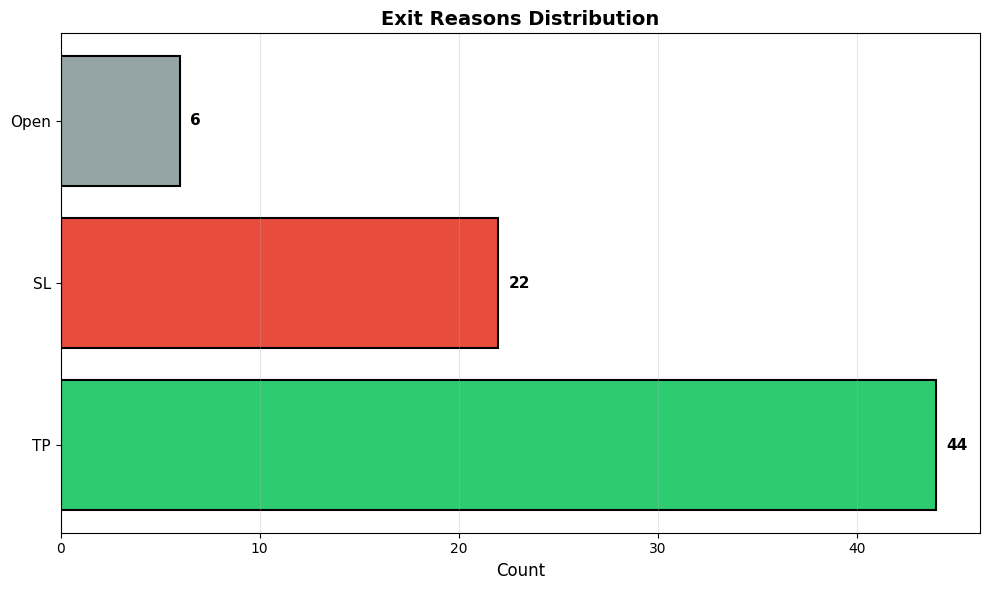

✓ Chart saved: ../plots/6_exit_reasons.png


In [81]:
# Chart 6: Exit Reasons (TP, SL, Open)
fig6, ax6 = plt.subplots(figsize=(10, 6))
exit_reasons = results["exit_reason"].value_counts()
exit_colors = ["#2ecc71", "#e74c3c", "#95a5a6"]  # TP=Green, SL=Red, Open=Grey
bars = ax6.barh(range(len(exit_reasons)), exit_reasons.values, color=exit_colors[:len(exit_reasons)], edgecolor='black', linewidth=1.5)
ax6.set_yticks(range(len(exit_reasons)))
ax6.set_yticklabels(exit_reasons.index, fontsize=11)
ax6.set_xlabel("Count", fontsize=12)
ax6.set_title("Exit Reasons Distribution", fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, v in enumerate(exit_reasons.values):
    ax6.text(v + 0.5, i, str(v), va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("../plots/6_exit_reasons.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ../plots/6_exit_reasons.png")

In [82]:
# Save Complete Trade Journal as Formatted Text Report
from datetime import datetime

# Create detailed journal text
journal_text = f"""
╔═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                              FIBONACCI BACKTEST - DETAILED TRADE JOURNAL (COMPLETE)                                          ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
SUMMARY METRICS:
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
├─ Total Trades: {len(results)}
├─ Winning Trades: {(results['outcome'] == 'WIN').sum()} ({(results['outcome'] == 'WIN').sum() / len(results) * 100:.1f}%)
├─ Losing Trades: {(results['outcome'] == 'LOSS').sum()} ({(results['outcome'] == 'LOSS').sum() / len(results) * 100:.1f}%)
├─ Open Trades: {(results['outcome'] == 'OPEN').sum()} ({(results['outcome'] == 'OPEN').sum() / len(results) * 100:.1f}%)
├─ Total PnL: {results['pnl_pips'].sum():.0f} pips
├─ Average Win: {results[results['outcome'] == 'WIN']['pnl_pips'].mean():.1f} pips
├─ Average Loss: {results[results['outcome'] == 'LOSS']['pnl_pips'].mean():.1f} pips
├─ Largest Win: {results['pnl_pips'].max():.0f} pips
├─ Largest Loss: {results['pnl_pips'].min():.0f} pips
├─ Risk-Reward Ratio: {rr:.2f}
└─ Profit Factor: {(results[results['outcome'] == 'WIN']['pnl_pips'].sum() / abs(results[results['outcome'] == 'LOSS']['pnl_pips'].sum())) if len(results[results['outcome'] == 'LOSS']) > 0 else 0:.2f}x

═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
PERFORMANCE BY FIBONACCI LEVEL:
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
"""

for level in sorted(results["fib_level"].unique()):
    level_trades = results[results["fib_level"] == level]
    level_wins = (level_trades["outcome"] == "WIN").sum()
    wr = level_wins / len(level_trades) * 100 if len(level_trades) > 0 else 0
    total_pnl = level_trades['pnl_pips'].sum()
    journal_text += f"├─ Level {level}: {len(level_trades)} trades | {wr:.1f}% WR | {total_pnl:+.0f} pips\n"

journal_text += f"""
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
PERFORMANCE BY DIRECTION:
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
"""

for direction in sorted(results["direction"].unique()):
    dir_trades = results[results["direction"] == direction]
    dir_wins = (dir_trades["outcome"] == "WIN").sum()
    wr = dir_wins / len(dir_trades) * 100 if len(dir_trades) > 0 else 0
    total_pnl = dir_trades['pnl_pips'].sum()
    journal_text += f"├─ {direction}: {len(dir_trades)} trades | {wr:.1f}% WR | {total_pnl:+.0f} pips\n"

journal_text += f"""
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
DETAILED TRADE LISTING (ALL {len(results)} TRADES):
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

"""

# Add each trade with full details
for idx, trade in results.iterrows():
    outcome_symbol = "✓ WIN" if trade['outcome'] == "WIN" else ("✗ LOSS" if trade['outcome'] == "LOSS" else "● OPEN")
    
    journal_text += f"""Trade #{idx+1} | {outcome_symbol}
├─ Session: {trade['entry_date']} {trade['entry_time']} → {trade['exit_date']} {trade['exit_time']}
├─ Direction: {trade['direction']}
├─ Fibonacci Level Touched: {trade['fib_level']}
├─ Entry Price: {trade['entry_price']:.2f}
├─ Exit Price: {trade['exit_price']:.2f}
├─ Exit Reason: {trade['exit_reason']} (Take Profit / Stop Loss / No Exit)
└─ P&L: {trade['pnl_pips']:+.0f} pips

"""

# Save to file
os.makedirs("../output", exist_ok=True)
with open("../output/detailed_trade_journal.txt", "w") as f:
    f.write(journal_text)

print(journal_text)
print("\n" + "="*120)
print("✓ Complete trade journal saved to: ../output/detailed_trade_journal.txt")


╔═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                              FIBONACCI BACKTEST - DETAILED TRADE JOURNAL (COMPLETE)                                          ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

Report Generated: 2025-12-07 10:34:39

═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
SUMMARY METRICS:
═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
├─ Total Trades: 72
├─ Winning Trades: 44 (61.1%)
├─ Losing Trades: 22 (30.6%)
├─ Open Trades: 6 (8.3%)
├─ Total PnL: 10475 pips
├─ Average Win: 267.6 pips
├─ Average Loss: -86.4 pips
├─ Largest Win: 325 pips
├─ Largest Loss: -100 pips
├─ Risk-Reward Ratio: 1.50
└─ Profit Factor: 6.20x

═════════